In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm.

In [2]:
train_dir="./custom/full/"
train_csv="./custom/train_data.csv"
test_dir="./custom/full/"
test_csv="./custom/test_data.csv"

In [3]:
df_train=pd.read_csv(train_csv)
df_train.head() #get first 5 rows.

,0,1,2
0,004/004_22.png,004/004_02.png,1
1,002/002_15.png,002_forg/002_forg_04.png,0
2,004/004_18.png,004/004_19.png,1
3,006/006_08.png,006_forg/006_forg_01.png,0
4,002/002_16.png,002/002_05.png,1


In [4]:
df_test = pd.read_csv(test_csv)
df_test.head()

,0,1,2
0,003/003_16.png,003_forg/003_forg_10.png,0
1,004/004_14.png,004/004_04.png,1
2,002/002_06.png,002/002_22.png,1
3,006/006_13.png,006/006_11.png,1
4,002/002_00.png,002_forg/002_forg_10.png,0


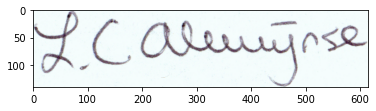

In [5]:
import matplotlib.pyplot as plt
img = plt.imread(train_dir+df_train.iat[1,0]) #1st row, 0th column
plt.imshow(img)

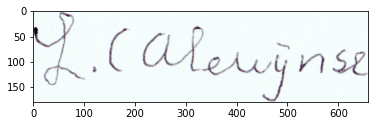

In [6]:
import matplotlib.pyplot as plt
img = plt.imread(train_dir+df_train.iat[1,1])
plt.imshow(img)

In [7]:
import cv2
test_images1 = [] #the genuine one.
test_images2 = [] #testing one. 

test_labels = []
for j in range(0,len(df_test)):
    img1 = cv2.imread(test_dir+df_test.iat[j,0])
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img1 = cv2.resize(img1, (100, 100))
    test_images1.append([img1])
    
    img2 = cv2.imread(test_dir+df_test.iat[j,1])
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    img2 = cv2.resize(img2, (100, 100))
    test_images2.append([img2])
    
    test_labels.append(np.array(df_test.iat[j,2]))

test_images1 = np.array(test_images1)/255.0 #pixel value 0 to 255. divide by 255, we get in 0 to 1 range. fast for computation.
test_images2 = np.array(test_images2)/255.0
test_labels = np.array(test_labels)

In [9]:
import cv2

train_images1 = []
train_images2 = []
train_labels = []

for i in range(len(df_train)):
    img1 = cv2.imread(train_dir+df_train.iat[i,0])
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img1 = cv2.resize(img1, (100, 100))
    train_images1.append([img1])
    
    img2 = cv2.imread(train_dir+df_train.iat[i,1])
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    img2 = cv2.resize(img2, (100, 100))
    train_images2.append([img2])
    
    train_labels.append(np.array(df_train.iat[i,2]))
    
train_images1 = np.array(train_images1)/255.0
train_images2 = np.array(train_images2)/255.0
train_labels = np.array(train_labels)

In [11]:
from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(train_labels)

In [12]:
train_images1.shape

(3672, 1, 100, 100)

In [13]:
train_labels.shape

(3672, 2, 2)

In [14]:
from sklearn.utils import shuffle
train_images1,train_images2,train_labels = shuffle(train_images1,train_images2,train_labels)
test_images1,test_images2,test_labels = shuffle(test_images1,test_images2,test_labels)

In [15]:
size = 100
train_images1 = train_images1.reshape(-1, size,size, 1) #to mention grey, added 1 in the end. {number of rows, height, width, numberof colors}
train_images2 = train_images2.reshape(-1, size,size, 1)
test_images1  = test_images1.reshape(-1, size,size, 1)
test_images2  = test_images2.reshape(-1, size,size, 1)

In [16]:
train_images1.shape

(3672, 100, 100, 1)

In [17]:
from keras import backend as K
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [18]:
input_dim = (100,100,1)

In [28]:
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import optimizers
from keras.models import load_model
from keras import applications

from keras import callbacks
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
import os
from keras.models import Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
import warnings
warnings.filterwarnings('ignore')

In [21]:
def build_base_network(input_shape):
    
    seq = Sequential()
    
    kernel_size = 3
    
    seq.add(Convolution2D(64, (kernel_size, kernel_size), input_shape=input_shape))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))  
    
    seq.add(Convolution2D(32, (kernel_size, kernel_size)))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))
    
    #flatten 
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dense(64, activation='relu'))
    return seq

base_network = build_base_network(input_dim)

img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

prediction = Dense(2,activation='softmax')(distance) #1 neuron, sigmoid shrinks distance between 0 and 1.

2022-03-15 03:52:39.079127: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-15 03:52:39.751306: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38421 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:0f:00.0, compute capability: 8.0


In [22]:
earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3, #tolerates 3 times opposition
                              verbose=1) #shows in terminal

callback_early_stop_reduceLROnPlateau=[earlyStopping]

In [23]:
model = Model([img_a, img_b],prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 64)           2194272     ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [24]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [29]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=0.00006)
              , metrics=["accuracy"])

In [30]:
history = model.fit([train_images1,train_images2], train_labels, validation_split=.30,
      batch_size= 32, verbose=1, epochs=20, callbacks=callback_early_stop_reduceLROnPlateau)

Epoch 1/20


ValueError: in user code:

    File "/home/jovyan/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/home/jovyan/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jovyan/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/home/jovyan/.local/lib/python3.8/site-packages/keras/engine/training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/jovyan/.local/lib/python3.8/site-packages/keras/engine/training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "/home/jovyan/.local/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/jovyan/.local/lib/python3.8/site-packages/keras/losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/jovyan/.local/lib/python3.8/site-packages/keras/losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/jovyan/.local/lib/python3.8/site-packages/keras/losses.py", line 1789, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/home/jovyan/.local/lib/python3.8/site-packages/keras/backend.py", line 5083, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 2, 2) and (None, 2) are incompatible


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

In [31]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

NameError: name 'epochs' is not defined

In [32]:
pred_y = model.predict([test_images1,test_images2])

2022-03-15 03:53:37.674123: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204
2022-03-15 03:53:49.907542: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [29]:
test_labels = np.array(df_test['1'])

In [30]:
from sklearn.metrics import accuracy_score
accuracy_score(pred_y.argmax(axis=1), test_labels)

0.5054811205846529